## Version 2 - Boss/client feedback
Oh no, the client has taken a look at our work and they are not happy.  
They spend a lot of money on that data and we have thrown away two whole columns without good reason.  
We need to update our feature engineering to include features based on the cabin and name columns,  
which should also hopefully improve the performance since they feel 74% is a little too low to put into production.  
Also the client doesn't know what to do with a .cbm file, they just want to be able to get new predictions whenever they get new data coming in.  
Let's first implement the new features so that we use the dropped columns and then we can think about getting the predictions to the client somehow.

In [1]:
!pip install catboost matplotlib pandas scikit-learn kaggle optuna ipywidgets kaleido shap


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Getting the data again.

In [2]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset = "titanic"  # original competition dataset
dataset_test = "wesleyhowe/titanic-labelled-test-set"  # test set augmented with target labels
download_folder = Path("data/titanic")
zip_path = download_folder / "titanic.zip"
download_folder.mkdir(parents=True, exist_ok=True)

api.competition_download_files(dataset, path=str(download_folder))
api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(str(download_folder))

os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/wesleyhowe/titanic-labelled-test-set


In [1]:
!dir "./data/titanic"

 Volume in drive C has no label.
 Volume Serial Number is D0EF-588E

 Directory of c:\Users\Wojciech\Documents\ML-Ops-repo\ARISA-MLOps\notebooks\data



File Not Found


Read in the data again and dropping passengerId, and now only ticket, since we will be using Name and Cabin.

In [4]:
import pandas as pd

df_train = pd.read_csv(download_folder / "train.csv")
df_ids = df_train.pop("PassengerId")  # set aside PassengerId

df_train.sample(10)

df_train = df_train.drop(columns=["Ticket"])
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


Quick regex match on the titles

In [5]:
import re
def extract_title(name):
    match = re.search(r',\s*([\w\s]+)\.', name)
    return match.group(1) if match else None
df_train["Title"] = df_train["Name"].apply(extract_title)
df_train.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
151,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,66.6000,C2,S,Mrs
335,0,3,"Denkoff, Mr. Mitto",male,NaN,0,0,7.8958,NaN,S,Mr
748,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,53.1000,D30,S,Mr
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,29.1250,NaN,Q,Master
354,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,7.2250,NaN,C,Mr


Looks about right:

In [6]:
df_train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

And for the Cabin we split into deck and cabin number:

In [7]:
# pattern to match a letter followed by a number
pattern = r'([A-Za-z]+)(\d+)'

# run pattern on Cabin to extract all matches
matches = df_train['Cabin'].str.extractall(pattern)
matches.reset_index(inplace=True)

# create a new column for each letter and number matched
result = matches.pivot(index='level_0', columns='match', values=[0, 1])
result.columns = [f"{col[0]}_{col[1]}" for col in result.columns]

# join to original train dataframe
df_train = df_train.join(result[["0_0", "1_0"]])

# fill nans
df_train["1_0"] = df_train["1_0"].astype(float)
df_train = df_train.fillna({"0_0": "N", "1_0": df_train["1_0"].mean()})
df_train["1_0"] = df_train["1_0"].astype(int)

# rename new columns and drop old ones
df_train = df_train.rename(columns={"0_0": "Deck", "1_0": "CabinNumber"})
df_train.drop(columns=["Cabin", "Name"], axis=1, inplace=True)

Fill remaining nans:

In [8]:
df_train = df_train.fillna({"Embarked": "N", "Age": df_train["Age"].mean()})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    object 
 8   Title        891 non-null    object 
 9   Deck         891 non-null    object 
 10  CabinNumber  891 non-null    int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 73.2+ KB


Get indices for categorical columns now including Title and Deck (CabinNumber is numerical):

In [9]:
categorical = [
    "Pclass", 
    "Sex", 
    "Embarked",
    "Deck",
    "Title"
]

y_train = df_train.pop("Survived")
X_train = df_train

categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
categorical_indices

[0, 1, 6, 8, 7]

And run the hyperparameter optimization:

In [10]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params_v2.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 50, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), cat_features=categorical_indices, early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 4, 'learning_rate': 0.22006324169065175, 'iterations': 163, 'l2_leaf_reg': 0.031900004970318356, 'bagging_temperature': 0.5964381011651683, 'random_strength': 0.0013931822006011051}


Do cross validation again:

In [11]:
params["eval_metric"] = "F1"
params["loss_function"] = "Logloss"

model = CatBoostClassifier(
    **params,
    verbose=True
)

data = Pool(X_train, y_train, cat_features=categorical_indices)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
)

cv_results.to_csv(outfolder / "cv_results_v2.csv", index=False)

Training on fold [0/5]
0:	learn: 0.7471264	test: 0.7692308	best: 0.7692308 (0)	total: 173ms	remaining: 28.1s
1:	learn: 0.7533461	test: 0.7938931	best: 0.7938931 (1)	total: 187ms	remaining: 15.1s
2:	learn: 0.7557252	test: 0.7938931	best: 0.7938931 (1)	total: 201ms	remaining: 10.7s
3:	learn: 0.7600768	test: 0.7938931	best: 0.7938931 (1)	total: 215ms	remaining: 8.54s
4:	learn: 0.7600768	test: 0.7938931	best: 0.7938931 (1)	total: 229ms	remaining: 7.25s
5:	learn: 0.7600768	test: 0.7938931	best: 0.7938931 (1)	total: 244ms	remaining: 6.38s
6:	learn: 0.7635659	test: 0.8000000	best: 0.8000000 (6)	total: 257ms	remaining: 5.74s
7:	learn: 0.7659574	test: 0.8000000	best: 0.8000000 (6)	total: 272ms	remaining: 5.28s
8:	learn: 0.7730769	test: 0.7938931	best: 0.8000000 (6)	total: 288ms	remaining: 4.92s
9:	learn: 0.7760618	test: 0.7938931	best: 0.8000000 (6)	total: 302ms	remaining: 4.61s
10:	learn: 0.7775629	test: 0.7938931	best: 0.8000000 (6)	total: 316ms	remaining: 4.36s
11:	learn: 0.7755906	test: 0.7

And get the performance plots:

In [12]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.show()

fig.write_image(outfolder / "test_f1_v2.png")

In [13]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

fig.show()

fig.write_image(outfolder / "test_logloss_v2.png")

Fit model on full dataset:

In [14]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    cat_features=categorical_indices,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_titanic_v2.cbm')
joblib.dump(params, outfolder / 'model_params_v2.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7321429	total: 14ms	remaining: 2.27s
50:	learn: 0.8535826	total: 709ms	remaining: 1.56s
100:	learn: 0.8813559	total: 1.45s	remaining: 889ms
150:	learn: 0.9115854	total: 2.19s	remaining: 174ms
162:	learn: 0.9160305	total: 2.36s	remaining: 0us


['results\\model_params_v2.pkl']

And now to copy paste the train preprocessing code to preprocess the test set, and run a prediction:

In [15]:
df_test = pd.read_csv(download_folder / "test.csv")
df_test = df_test.drop(columns=["Ticket"])
df_test_id = df_test.pop("PassengerId")
df_test = df_test.fillna({"Embarked": "N", "Age": X_train["Age"].mean()})

pattern = r'([A-Za-z]+)(\d+)'
matches = df_test['Cabin'].str.extractall(pattern)
matches.reset_index(inplace=True)
result = matches.pivot(index='level_0', columns='match', values=[0, 1])
result.columns = [f"{col[0]}_{col[1]}" for col in result.columns]
df_test = df_test.join(result[["0_0", "1_0"]])
df_test["1_0"] = df_test["1_0"].astype(float)
df_test = df_test.fillna({"0_0": "N", "1_0": X_train["CabinNumber"].mean()})
df_test["1_0"] = df_test["1_0"].astype(int)
df_test = df_test.rename(columns={"0_0": "Deck", "1_0": "CabinNumber"})

df_test["Title"] = df_test["Name"].apply(extract_title)

df_test.drop(columns=["Cabin", "Name"], axis=1, inplace=True)
df_test["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [16]:
preds = model.predict(df_test[X_train.columns])

Get the shapley overview plot showing the importance of the new features as well:

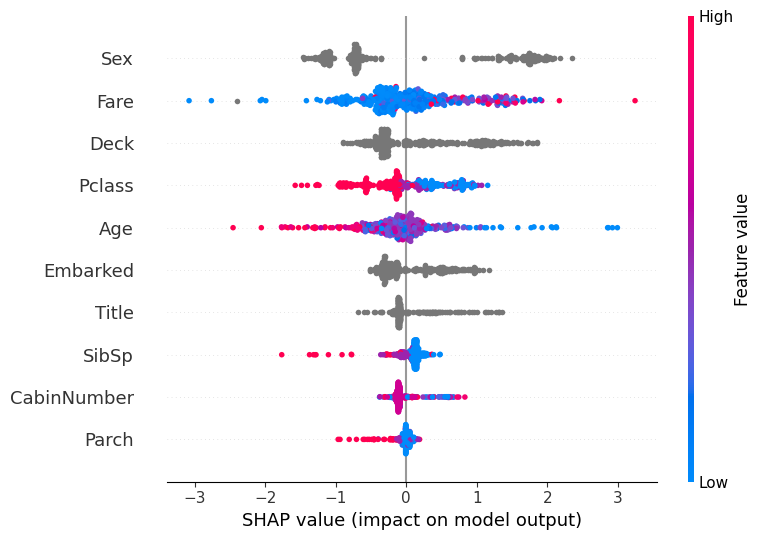

In [17]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[X_train.columns])

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall_v2.png")

And finally let's get the score on the test set:

In [18]:
df_test["PassengerId"] = df_test_id
df_test["Survived"] = preds

df_test[["PassengerId", "Survived"]].to_csv(outfolder / "predictions_v2.csv", index=False)

And submitting again to kaggle we get a slight improvement but with the client happier that we used all the data at least:
  
![screenshot of kaggle submission page v2 with prediction performance of 0.76555](results/kaggle_result_v2.png "Kaggle Result")